In [1]:
from datetime import timedelta, datetime, timezone
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from utils import \
    get_prices, \
    plot_heatmap, \
    plot_errors_hist, \
    plot_estimators_hist, \
    plot_returns_and_filter, \
    load_results, \
    apply_kalman_filter, \
    compute_features, \
    load_data, \
    resample_data

In [2]:
start_time_ = datetime(2019, 11, 27, tzinfo=timezone.utc)
end_time_ = datetime(2020, 2, 4, tzinfo=timezone.utc)

# duration = timedelta(days=int((end_time_ - start_time_).days))
# df_ = get_prices('btc', 'usdt', start_time_, duration=duration, proxy_port='8815', verbose=2)

df_ = load_data(start_time_, end_time_)

timeframe = timedelta(minutes=5)
df = resample_data(df_, timeframe, start_time_, end_time_)
df

,Open,High,Low,Close,Volume,Value,No. Trades,Taker Buy Volume,Taker Buy Value,Average Price,Average Price Change
2019-11-27 00:00:00,7154.75,7164.59,7140.54,7162.89,164.200264,1174322.858921,1234,103.771014,742217.277131,7151.772051,NaN
2019-11-27 00:05:00,7164.4,7169.00,7152.92,7157.86,115.531698,827553.413765,904,73.404774,525826.737982,7162.998797,0.001570
2019-11-27 00:10:00,7157.32,7160.19,7144.93,7151.68,112.780186,806537.314318,914,57.210353,409185.53799,7151.409684,-0.001618
2019-11-27 00:15:00,7152.16,7152.20,7138.93,7142.66,157.903923,1128196.518585,833,70.53854,503984.524916,7144.828939,-0.000920
2019-11-27 00:20:00,7142.63,7148.81,7138.94,7146.63,71.999481,514385.20938,638,42.162902,301241.148857,7144.290518,-0.000075
...,...,...,...,...,...,...,...,...,...,...,...
2020-02-03 23:35:00,9298.38,9300.35,9277.07,9294.66,148.543688,1379949.554079,1348,82.834562,769549.767916,9289.856558,-0.000593
2020-02-03 23:40:00,9294.66,9307.69,9294.01,9304.29,90.220836,839207.947381,908,64.413847,599153.526012,9301.708836,0.001276
2020-02-03 23:45:00,9304.0,9319.99,9295.98,9316.82,139.875918,1301847.098326,1874,68.115588,633991.892739,9307.156778,0.000586
2020-02-03 23:50:00,9316.15,9316.88,9303.73,9306.52,95.824739,892149.993958,1331,45.580965,424366.578549,9310.226182,0.000330


# Validation to find best memory size m

In [3]:
# from scipy.stats import pearsonr
# tmp = [(1., 0), ]
# for i in range(360):
#     if i == 0:
#         x = (df['Average Price'].shift(-1) / df['Average Price'] - 1) * 100 * RETURN_SCALE
#     else:
#         y = (df['Average Price'].shift(-i-1) / df['Average Price'] - 1) * 100 * RETURN_SCALE
#         intersection = sorted(list(set(x.dropna().index).intersection(set(y.dropna().index))))
#         tmp.append(pearsonr(x.loc[intersection], y.loc[intersection]))
# tmp = np.array(tmp)

In [4]:
# %matplotlib inline
# plt.figure(figsize=(10, 3), dpi=120)
# plt.plot(np.log2(tmp[:, 0]))
# plt.title('BTC Price Change Memory')
# txt = "correlation diagram (in binary logarithmic scale) of BTC price return with cummulative price return up to some future point"
# plt.gcf().text(0.5, -0.1, txt, wrap=False, horizontalalignment='center', fontsize=8)
# plt.xlabel('time elapsed (minutes)')
# plt.ylabel('correlation (logarithmic)')
# plt.xticks(np.arange(25) * 15, fontsize=5)
# plt.yticks(np.arange(0, -5, -1))
# plt.grid()
# for i in range(-1, -5, -1):
#     point = np.where(np.log2(tmp[:, 0]) >= i)[0][-1]
#     plt.scatter(point, np.log2(tmp[point, 0]), marker='x', label=str(point))
# plt.legend()
# plt.savefig("Correlation.png")
# plt.show()

# Linear Model without Control

In [5]:
# m = 15
#
# X = pd.DataFrame(index=df.index)
# for i in range(m):
#     X[f'Average Price Change from last {i} candle so far'] = \
#         df['Average Price'].pct_change(1 if i == 0 else i).shift(-1 if i == 0 else 0)
#
# period_start = datetime(2019, 12, 1)
# period_start_iloc = np.where(df.index == period_start)[0][0]
# period_end = datetime(2020, 2, 1)
# period_end_iloc = np.where(df.index == period_end)[0][0]
#
# for k in np.arange(1, 16)*64 + 63:
#     THETA = []
#     results = pd.DataFrame(index=df.index)
#     results['Prediction'] = None
#     results['Measurement'] = None
#     results['Model Noise Bias'] = None
#     for n in np.arange(period_start_iloc, period_end_iloc):
#         A = np.zeros([k, m])
#         A[:, range(m)] = X.iloc[(n-2)-(k-1):(n-2)+1].to_numpy()
#         b = X.iloc[(n-1)-(k-1):(n-1)+1, 0].values
#         theta, _, _, _ = np.linalg.lstsq(A, b, rcond=-1)
#         THETA.append(theta)
#         pos = results.index[n]
#         results.loc[pos, 'Model Noise Bias'] = (np.dot(A, theta) - b).mean()
#         results.loc[pos, 'Prediction'] = np.dot(theta, X.iloc[n-1].values) + results.loc[pos, 'Model Noise Bias']
#         results.loc[pos, 'Measurement'] = df.iloc[n]['Open'] / df.iloc[n-1]['Average Price'] - 1
#
#     indices = df.index[period_start_iloc:period_end_iloc]
#     results = results.loc[indices]
#     results['Reality'] = df['Average Price Change'].shift(-1).loc[indices].values
#     THETA = pd.DataFrame(THETA, index=indices)
#     pd.concat([results, THETA], axis=1).to_csv(f'data/linear_model_without_control[k={k},m={m}]')
#
#     t = np.bincount(np.sign(results['Prediction']) == np.sign(results['Reality']))
#     print(t[1] / (t[0]+t[1]) * 100)
#     print('STANDARD ERRORS')
#     for c_label in ['Prediction', 'Measurement']:
#         print('  > {:13s}{:.5f}'.format(c_label + ':', (results[c_label] - results['Reality']).std()))
#     print('  > {:13s}{:.5f}'.format('Reality:', (results['Reality']-df['Average Price Change'].loc[indices].values).std()))

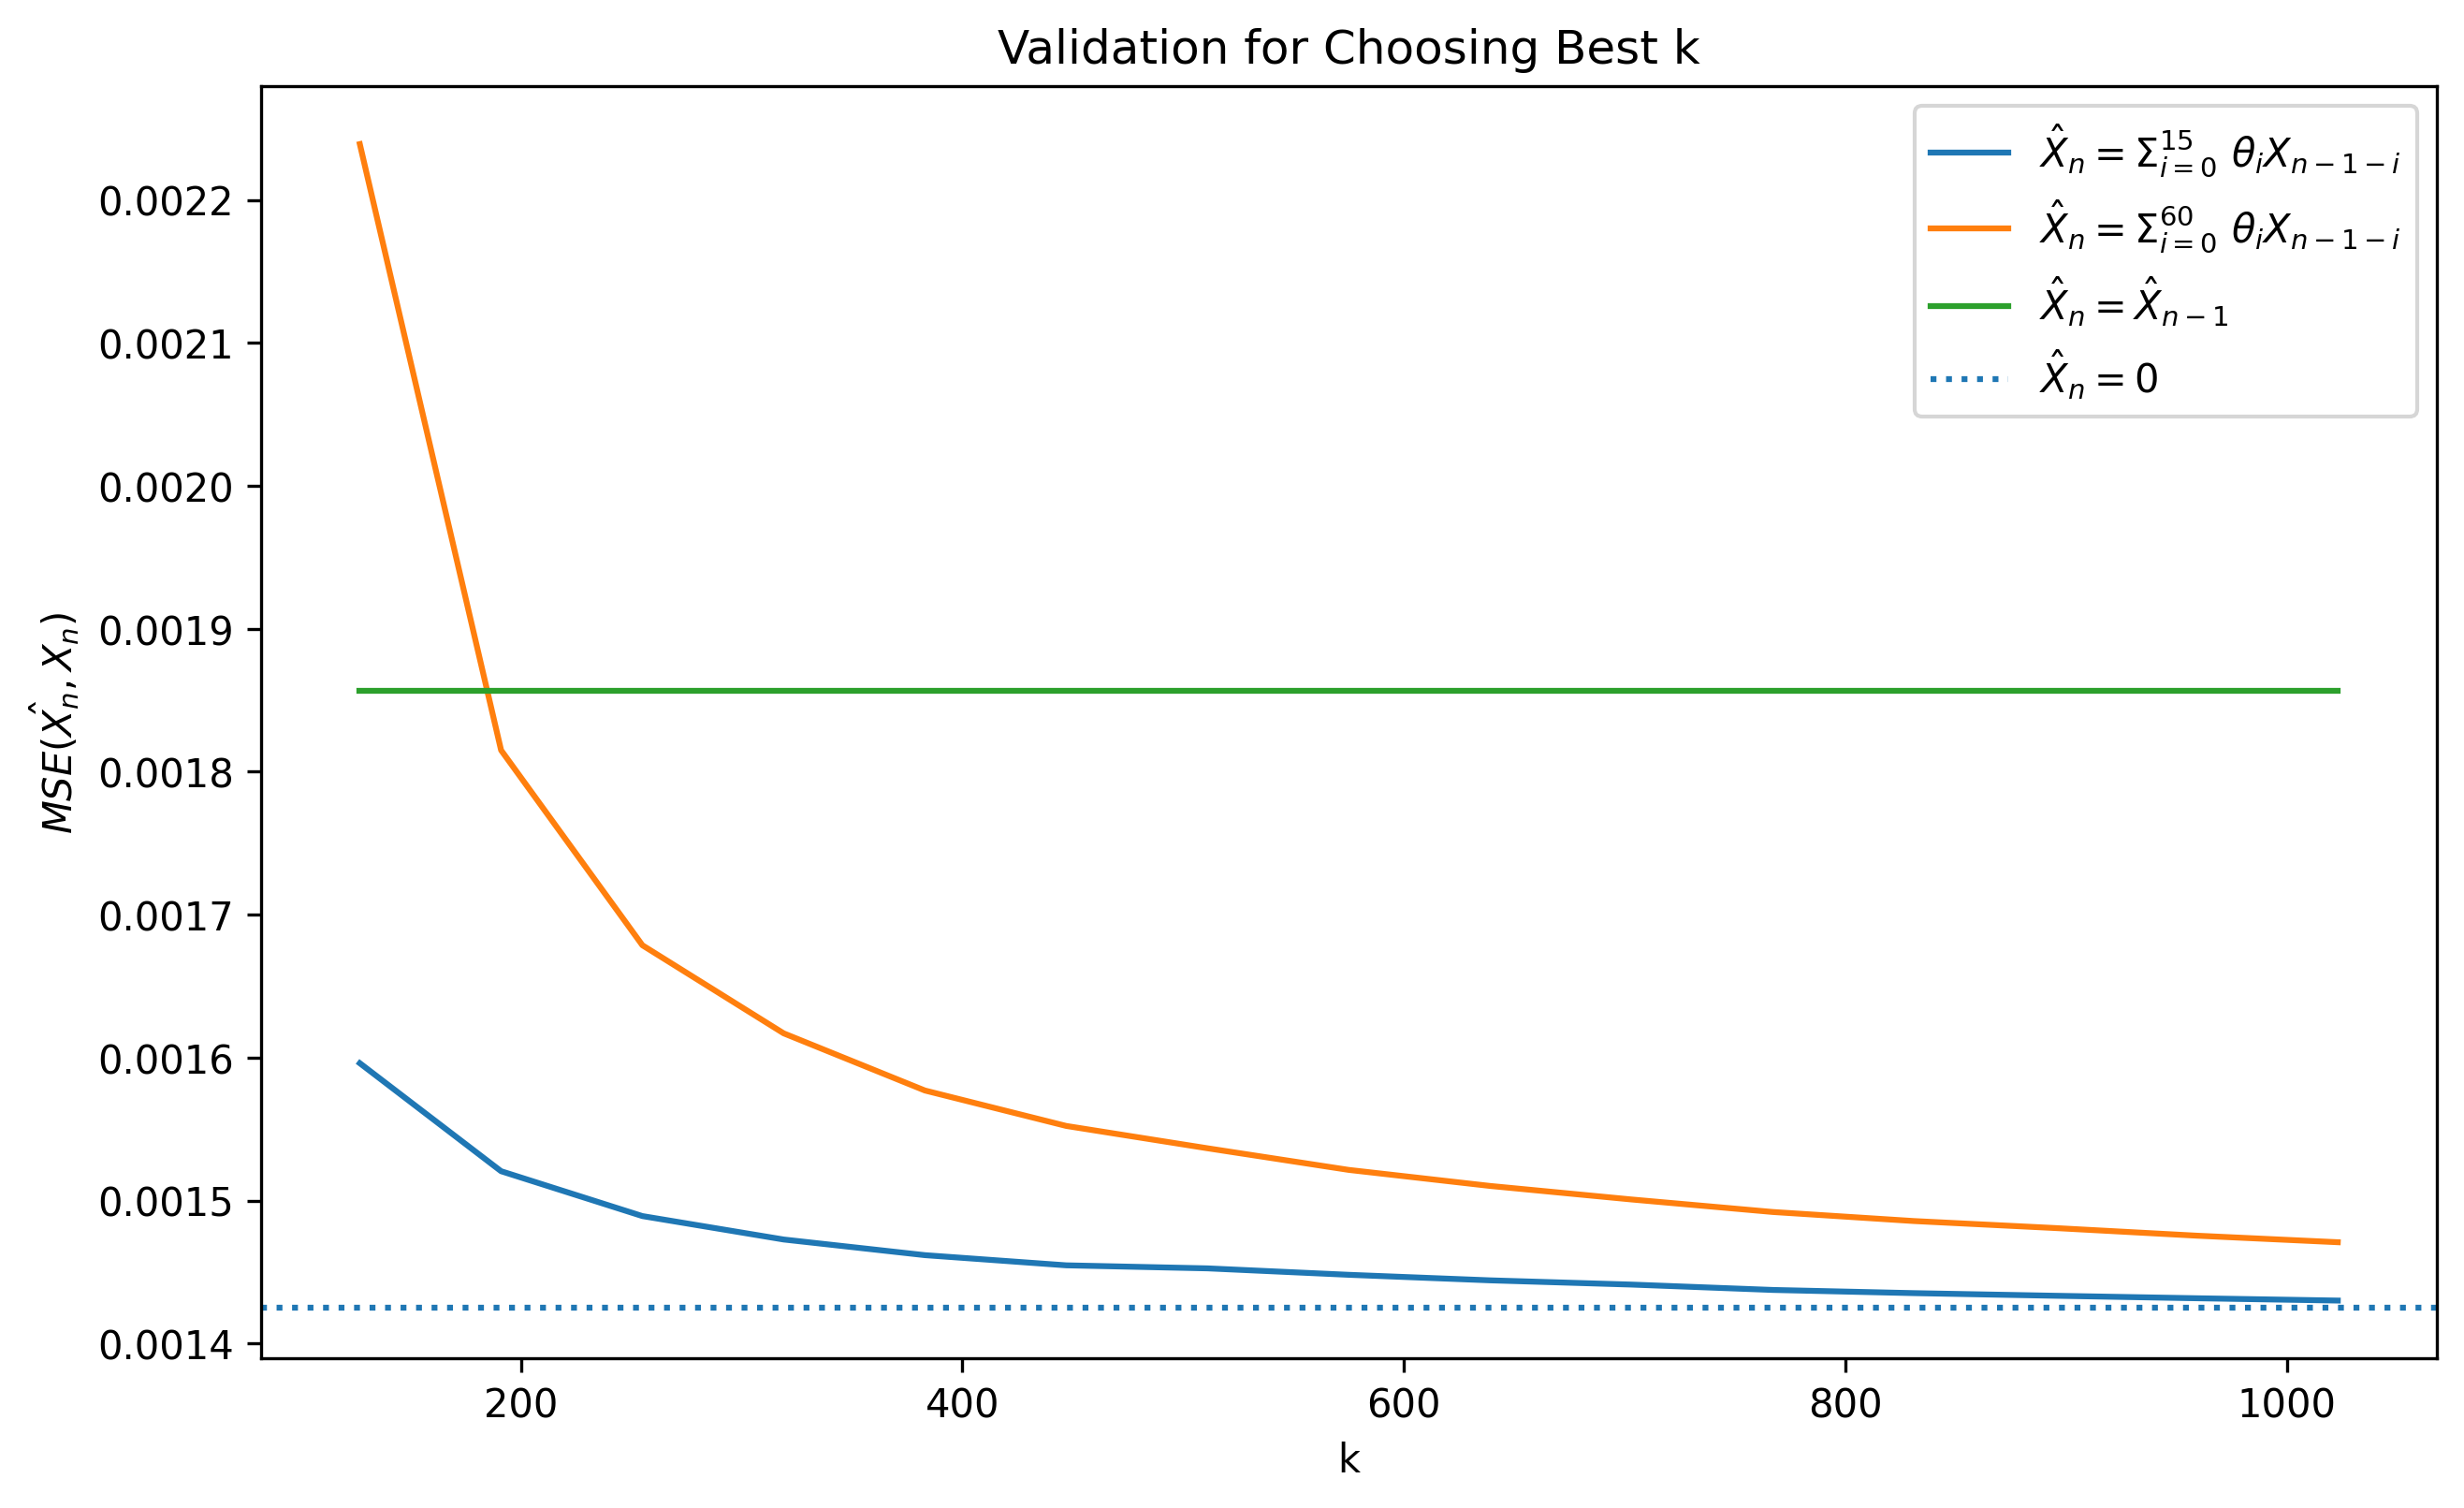

In [6]:
stds = [[], []]
results = None
for i, m in enumerate([15, 60]):
    for k in np.arange(1, 16)*64 + 63:
        results = pd.read_csv(f'data/linear_model_without_control[k={k},m={m}]')
        tmp = results['Prediction'].astype(float) - results['Reality'].astype(float)
        stds[i].append(tmp.std())

plt.figure(figsize=(10, 6), dpi=300)

plt.plot(range(127, 1087, 64), stds[0], label=r'$\hat{X}_n = \Sigma_{i=0}^{15}\ \theta_i X_{n-1-i}$')
plt.plot(range(127, 1087, 64), stds[1], label=r'$\hat{X}_n = \Sigma_{i=0}^{60}\ \theta_i X_{n-1-i}$')

tmp = results['Reality'].astype(float)
plt.plot([127, 1023], [(tmp-tmp.shift(1)).dropna().std(), (tmp-tmp.shift(1)).dropna().std()], label=r'$\hat{X}_n = \hat{X}_{n-1}$')
plt.axhline(tmp.std(), label=r'$\hat{X}_n = 0$', linestyle=':')

plt.legend()
plt.title('Validation for Choosing Best k')
plt.ylabel(r'$MSE(\hat{X_n}, X_n)$')
plt.xlabel('k')

plt.savefig('plots/best_k.png')
plt.show()

In [6]:
title, k, m = 'Linear Model without Control', 511, 15
results = load_results(title, k, m)
results

,Prediction,Measurement,Model Noise Bias,Reality,0,1,2,3,4,5,...,12,13,14,15,16,17,18,19,20,21
2019-12-01 00:00:00,-0.000320,-0.000246,0.000003,-0.001031,0.083256,0.059598,0.033870,-0.106701,-0.057984,-0.002032,...,-0.139606,0.007428,0.105871,0.000877,0.005730,-0.000062,-0.001101,0.000081,-0.000182,0.000637
2019-12-01 00:05:00,0.000002,-0.000688,0.000003,-0.002840,0.083507,0.059063,0.033260,-0.105626,-0.058569,-0.001170,...,-0.139894,0.007055,0.106414,0.000876,0.005733,-0.000061,-0.001102,0.000081,-0.000200,0.000625
2019-12-01 00:10:00,-0.000163,-0.000605,0.000003,-0.000342,0.085377,0.062108,0.031340,-0.107404,-0.054969,-0.003230,...,-0.139243,0.004558,0.108022,0.000867,0.005740,-0.000075,-0.001102,0.000091,-0.000168,0.000644
2019-12-01 00:15:00,0.000530,0.000014,0.000003,-0.001469,0.085424,0.062296,0.031513,-0.107384,-0.055598,-0.002700,...,-0.139414,0.004269,0.108287,0.000865,0.005713,-0.000075,-0.001096,0.000090,-0.000176,0.000648
2019-12-01 00:20:00,0.000366,-0.001108,0.000003,-0.000018,0.085929,0.064449,0.031951,-0.106431,-0.057479,-0.001503,...,-0.139893,0.005295,0.107974,0.000866,0.005761,-0.000080,-0.001110,0.000107,-0.000164,0.000617
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-31 23:35:00,0.000452,0.001077,0.000012,0.000035,0.071350,-0.129127,0.009263,-0.003783,-0.008132,0.019355,...,0.075648,-0.007254,-0.000922,0.001136,0.004604,-0.000287,-0.000807,0.000408,0.000471,0.001906
2020-01-31 23:40:00,-0.000171,0.000342,0.000012,-0.003235,0.071982,-0.128932,0.009459,-0.003679,-0.007901,0.018658,...,0.076883,-0.007369,-0.001059,0.001145,0.004633,-0.000293,-0.000813,0.000429,0.000487,0.001928
2020-01-31 23:45:00,-0.000654,-0.000170,0.000013,-0.001554,0.074024,-0.137809,0.009597,-0.002333,-0.006089,0.026361,...,0.076680,-0.011026,0.000223,0.001142,0.004667,-0.000290,-0.000818,0.000424,0.000518,0.001941
2020-01-31 23:50:00,0.000222,-0.000945,0.000013,0.000073,0.077746,-0.138638,0.009375,-0.002276,-0.005767,0.027313,...,0.077295,-0.010840,0.001214,0.001160,0.004762,-0.000302,-0.000834,0.000428,0.000569,0.001956


In [7]:
apply_kalman_filter(results)
results

,Prediction,Measurement,Model Noise Bias,Reality,0,1,2,3,4,5,...,19,20,21,Measurement Residual,Prediction Residual,Measurement Residual Weighted Variance,Prediction Residual Weighted Variance,Kalman Gain,Estimate,Estimate Uncertainty
2019-12-01 00:00:00,-0.000320,-0.000246,0.000003,-0.001031,0.083256,0.059598,0.033870,-0.106701,-0.057984,-0.002032,...,0.000081,-0.000182,0.000637,0.000785,0.000711,NaN,NaN,NaN,NaN,NaN
2019-12-01 00:05:00,0.000002,-0.000688,0.000003,-0.002840,0.083507,0.059063,0.033260,-0.105626,-0.058569,-0.001170,...,0.000081,-0.000200,0.000625,0.002152,0.002842,NaN,NaN,NaN,NaN,NaN
2019-12-01 00:10:00,-0.000163,-0.000605,0.000003,-0.000342,0.085377,0.062108,0.031340,-0.107404,-0.054969,-0.003230,...,0.000091,-0.000168,0.000644,-0.000263,0.000179,NaN,NaN,NaN,NaN,NaN
2019-12-01 00:15:00,0.000530,0.000014,0.000003,-0.001469,0.085424,0.062296,0.031513,-0.107384,-0.055598,-0.002700,...,0.000090,-0.000176,0.000648,0.001483,0.001999,NaN,NaN,NaN,NaN,NaN
2019-12-01 00:20:00,0.000366,-0.001108,0.000003,-0.000018,0.085929,0.064449,0.031951,-0.106431,-0.057479,-0.001503,...,0.000107,-0.000164,0.000617,-0.001090,0.000384,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-31 23:35:00,0.000452,0.001077,0.000012,0.000035,0.071350,-0.129127,0.009263,-0.003783,-0.008132,0.019355,...,0.000408,0.000471,0.001906,0.001042,0.000417,0.000001,0.000002,0.576454,0.000812,7.561030e-07
2020-01-31 23:40:00,-0.000171,0.000342,0.000012,-0.003235,0.071982,-0.128932,0.009459,-0.003679,-0.007901,0.018658,...,0.000429,0.000487,0.001928,0.003577,0.003064,0.000001,0.000002,0.530250,0.000101,7.943846e-07
2020-01-31 23:45:00,-0.000654,-0.000170,0.000013,-0.001554,0.074024,-0.137809,0.009597,-0.002333,-0.006089,0.026361,...,0.000424,0.000518,0.001941,0.001383,0.000899,0.000002,0.000002,0.527244,-0.000399,8.025177e-07
2020-01-31 23:50:00,0.000222,-0.000945,0.000013,0.000073,0.077746,-0.138638,0.009375,-0.002276,-0.005767,0.027313,...,0.000428,0.000569,0.001956,-0.001019,0.000149,0.000002,0.000002,0.524556,-0.000390,8.055559e-07


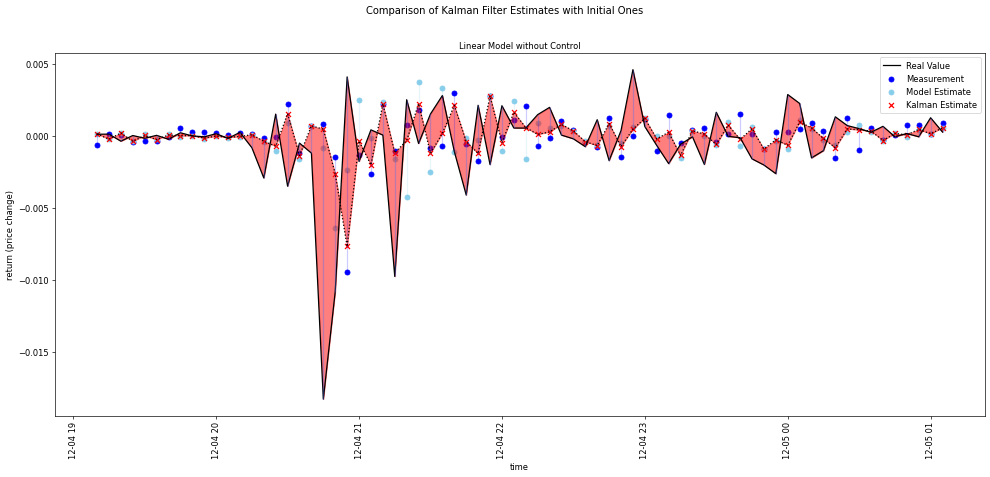

In [8]:
indices = results.index[np.arange(12*6) + int(288*3.8)]
plot_returns_and_filter(results, indices, title)

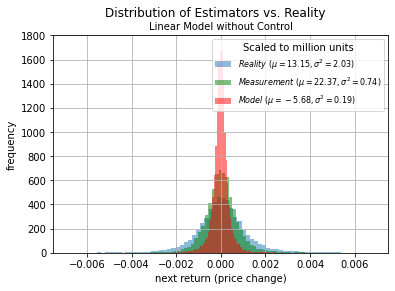

In [8]:
plot_estimators_hist(results, title)

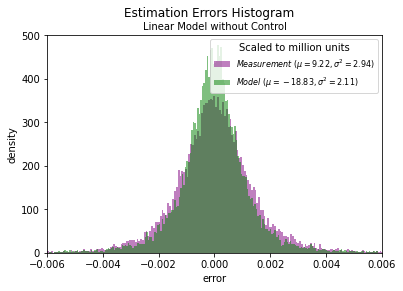

In [10]:
plot_errors_hist(results, title)

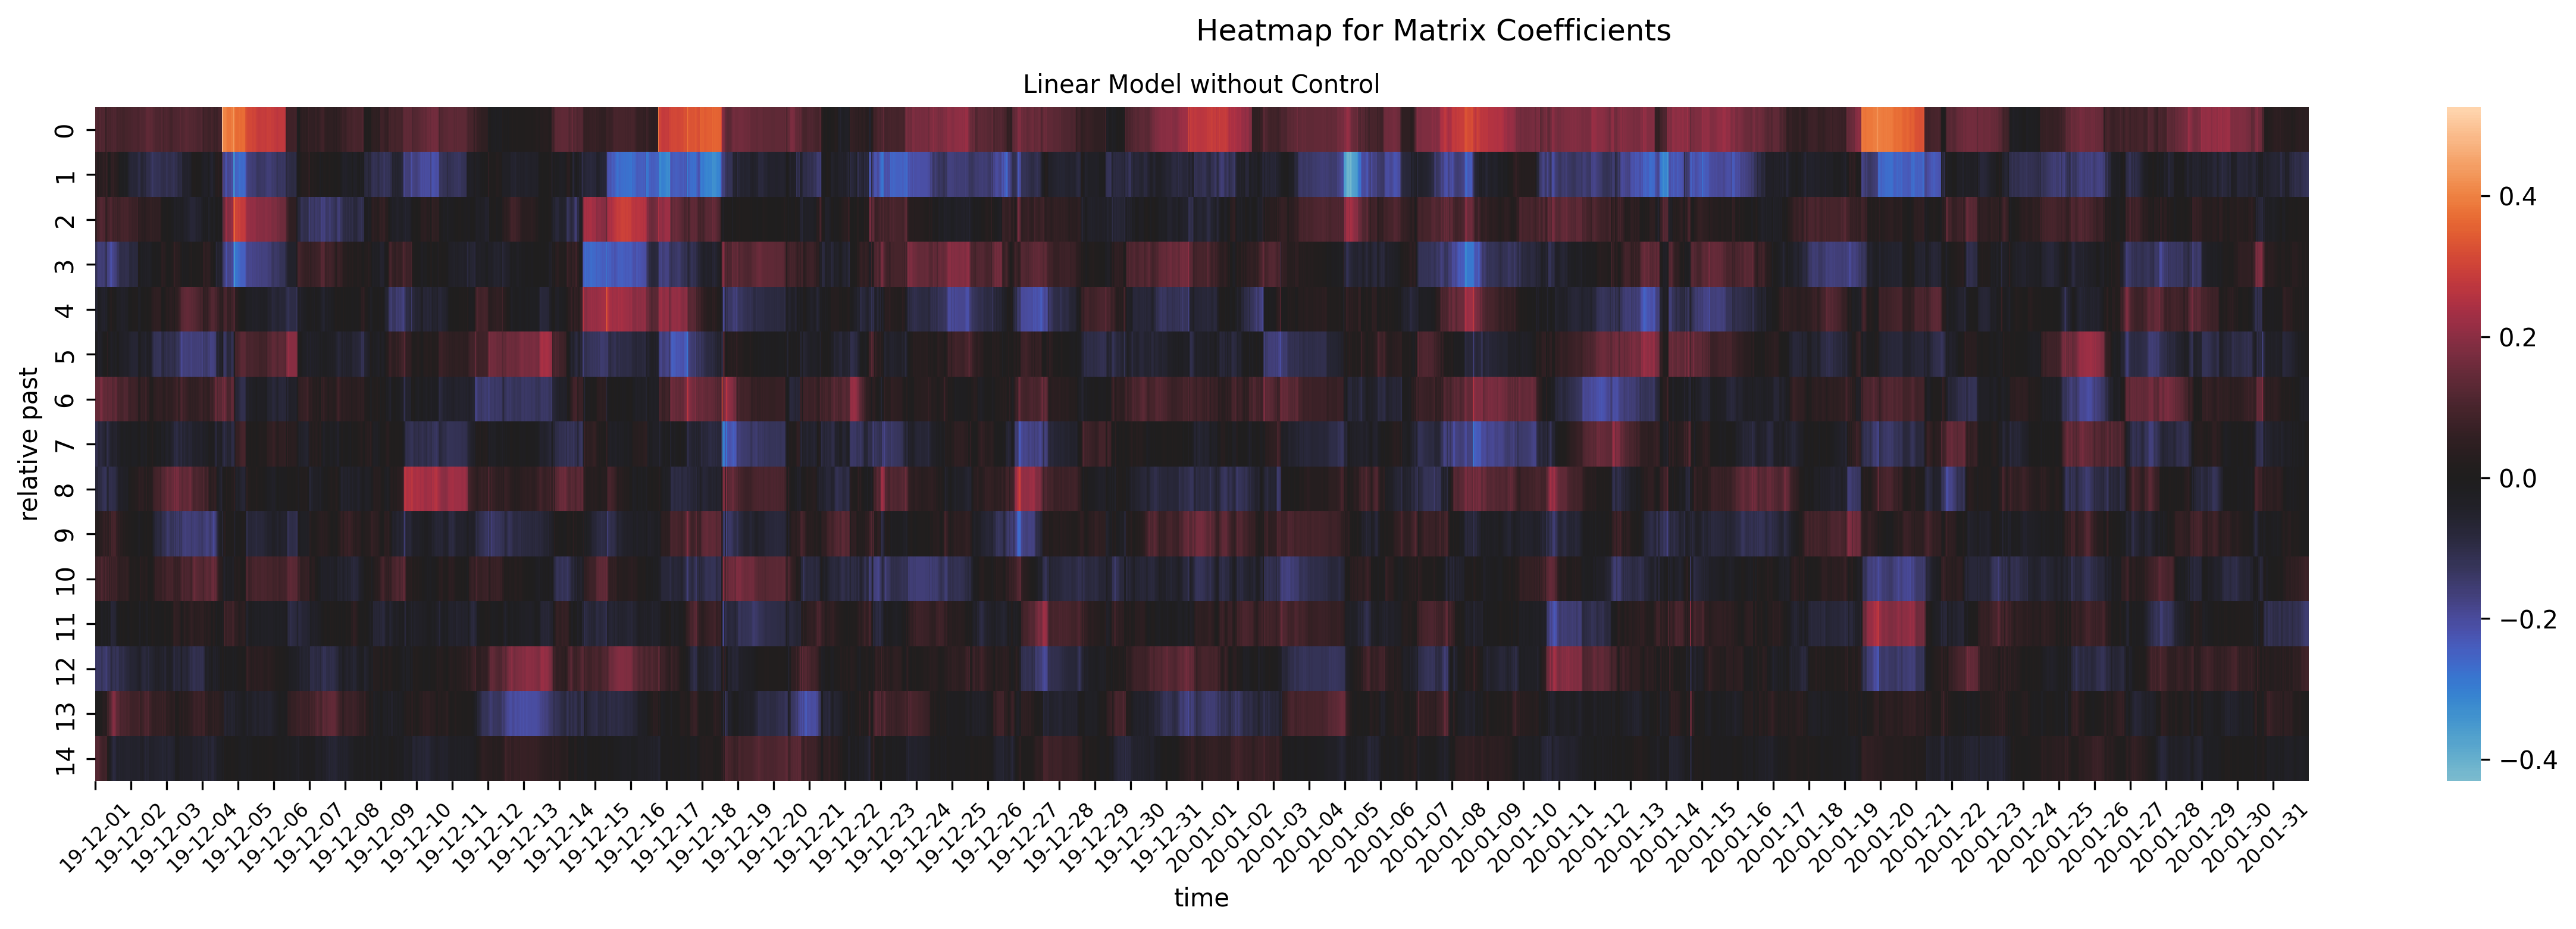

In [11]:
plot_heatmap(results[[f'{i}' for i in range(m)]], title)

# Linear Model with Control

In [3]:
features = compute_features(df)
features

,taker buy volume ratio,volume (1e3),volume change,trades number (1e3),trades number change,taker buy average spread (1e-3),taker sell average spread (1e-3)
2019-11-27 00:00:00,0.631978,0.1642,NaN,1.234,NaN,0.095183,-0.163451
2019-11-27 00:05:00,0.635365,0.115532,-0.296398,0.904,-0.267423,0.05407,-0.094216
2019-11-27 00:10:00,0.507273,0.11278,-0.023816,0.914,0.011062,0.124325,-0.127995
2019-11-27 00:15:00,0.446718,0.157904,0.400103,0.833,-0.088621,-0.002534,0.002046
2019-11-27 00:20:00,0.5856,0.071999,-0.544030,0.638,-0.234094,0.056861,-0.080352
...,...,...,...,...,...,...,...
2020-02-03 23:35:00,0.557644,0.148544,1.582849,1.348,0.829037,0.037126,-0.046801
2020-02-03 23:40:00,0.713958,0.090221,-0.392631,0.908,-0.326409,-0.008885,0.022178
2020-02-03 23:45:00,0.486972,0.139876,0.550373,1.874,1.063877,0.046432,-0.044074
2020-02-03 23:50:00,0.47567,0.095825,-0.314930,1.331,-0.289755,-0.005927,0.005377


In [10]:
# m = 15
# k = 511
# r = len(features.columns)
#
# X = pd.DataFrame(index=df.index)
# for i in range(m):
#     X[f'Average Price Change from last {i} candle so far'] = \
#         df['Average Price'].pct_change(1 if i == 0 else i).shift(-1 if i == 0 else 0)
#
# period_start = datetime(2019, 12, 1)
# period_start_iloc = np.where(df.index == period_start)[0][0]
# period_end = datetime(2020, 2, 1)
# period_end_iloc = np.where(df.index == period_end)[0][0]
#
# THETA = []
# results = pd.DataFrame(index=df.index)
# results['Prediction'] = None
# results['Measurement'] = None
# results['Model Noise Bias'] = None
# for n in np.arange(period_start_iloc, period_end_iloc):
#     A = np.zeros([k, m+r])
#     A[:, range(m)] = X.iloc[(n-2)-(k-1):(n-2)+1].to_numpy()
#     A[:, range(m, m+r)] = features.iloc[(n-1)-(k-1):(n-1)+1]
#     b = X.iloc[(n-1)-(k-1):(n-1)+1, 0].values
#     theta, _, _, _ = np.linalg.lstsq(A, b, rcond=-1)
#     THETA.append(theta)
#     pos = results.index[n]
#     results.loc[pos, 'Model Noise Bias'] = (np.dot(A, theta) - b).mean()
#     results.loc[pos, 'Prediction'] = np.dot(theta[0:m], X.iloc[n-1].values) +\
#                                      np.dot(theta[m:m+r], features.iloc[n].values) +\
#                                      results.loc[pos, 'Model Noise Bias']
#     results.loc[pos, 'Measurement'] = df.iloc[n]['Open'] / df.iloc[n-1]['Average Price'] - 1
#
# indices = df.index[period_start_iloc:period_end_iloc]
# results = results.loc[indices]
# results['Reality'] = df['Average Price Change'].shift(-1).loc[indices].values
# THETA = pd.DataFrame(THETA, index=indices)
# pd.concat([results, THETA], axis=1).to_csv(f'data/linear_model_with_control[k={k},m={m}]')
#
# t = np.bincount(np.sign(results['Prediction']) == np.sign(results['Reality']))
# print(t[1] / (t[0]+t[1]) * 100)
# print('STANDARD ERRORS')
# for c_label in ['Prediction', 'Measurement']:
#     print('  > {:13s}{:.5f}'.format(c_label + ':', (results[c_label] - results['Reality']).std()))
# print('  > {:13s}{:.5f}'.format('Reality:', (results['Reality']-df['Average Price Change'].loc[indices].values).std()))

In [11]:
r = len(features.columns)
title, k, m = 'Linear Model with Control', 511, 15
results = load_results(title, k, m)
results

,Prediction,Measurement,Model Noise Bias,Reality,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
2019-12-01 00:00:00,-0.000189,-0.000246,-0.000019,-0.001031,0.113922,0.045305,0.061919,-0.123994,-0.057233,-0.016942,0.145547,-0.103968,-0.073377,0.030561,0.075360,0.003972,-0.139930,-0.003677,0.117482
2019-12-01 00:05:00,-0.000154,-0.000688,-0.000018,-0.002840,0.114347,0.044495,0.061357,-0.122726,-0.058032,-0.015771,0.144662,-0.104042,-0.073753,0.031038,0.075232,0.004115,-0.140074,-0.004453,0.118317
2019-12-01 00:10:00,-0.000154,-0.000605,-0.000014,-0.000342,0.116127,0.047739,0.058781,-0.124072,-0.054519,-0.017592,0.147949,-0.106745,-0.073491,0.029768,0.076635,0.003769,-0.139289,-0.006272,0.119318
2019-12-01 00:15:00,0.000281,0.000014,-0.000015,-0.001469,0.116174,0.047683,0.059310,-0.124265,-0.055237,-0.016832,0.147342,-0.105793,-0.074297,0.029474,0.076781,0.004233,-0.139585,-0.006536,0.119642
2019-12-01 00:20:00,0.000283,-0.001108,-0.000009,-0.000018,0.116690,0.050325,0.058944,-0.122913,-0.057029,-0.015902,0.148574,-0.105632,-0.074386,0.029479,0.077740,0.002834,-0.139744,-0.005785,0.119280
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-31 23:35:00,0.000152,0.001077,-0.000016,0.000035,0.038716,-0.119047,0.009629,0.007801,0.004297,-0.000416,-0.029159,0.007504,-0.007131,-0.004551,0.070327,-0.148447,0.087195,0.003179,-0.020653
2020-01-31 23:40:00,-0.000232,0.000342,-0.000015,-0.003235,0.038384,-0.119111,0.009691,0.007901,0.004780,-0.000865,-0.029012,0.007401,-0.007190,-0.003910,0.070005,-0.148356,0.086756,0.003368,-0.020747
2020-01-31 23:45:00,0.000082,-0.000170,-0.000010,-0.001554,0.038891,-0.127766,0.009413,0.009471,0.006574,0.006896,-0.036808,0.008300,-0.012540,-0.000116,0.076437,-0.150249,0.087062,-0.001297,-0.019277
2020-01-31 23:50:00,0.000505,-0.000945,-0.000008,0.000073,0.044124,-0.126875,0.006429,0.009699,0.007390,0.007684,-0.033682,0.005065,-0.012871,-0.003952,0.080171,-0.149859,0.088682,-0.002208,-0.019436


In [12]:
apply_kalman_filter(results)
results

,Prediction,Measurement,Model Noise Bias,Reality,0,1,2,3,4,5,...,12,13,14,Measurement Residual,Prediction Residual,Measurement Residual Weighted Variance,Prediction Residual Weighted Variance,Kalman Gain,Estimate,Estimate Uncertainty
2019-12-01 00:00:00,-0.000189,-0.000246,-0.000019,-0.001031,0.113922,0.045305,0.061919,-0.123994,-0.057233,-0.016942,...,-0.139930,-0.003677,0.117482,0.000785,0.000842,NaN,NaN,NaN,NaN,NaN
2019-12-01 00:05:00,-0.000154,-0.000688,-0.000018,-0.002840,0.114347,0.044495,0.061357,-0.122726,-0.058032,-0.015771,...,-0.140074,-0.004453,0.118317,0.002152,0.002686,NaN,NaN,NaN,NaN,NaN
2019-12-01 00:10:00,-0.000154,-0.000605,-0.000014,-0.000342,0.116127,0.047739,0.058781,-0.124072,-0.054519,-0.017592,...,-0.139289,-0.006272,0.119318,-0.000263,0.000188,NaN,NaN,NaN,NaN,NaN
2019-12-01 00:15:00,0.000281,0.000014,-0.000015,-0.001469,0.116174,0.047683,0.059310,-0.124265,-0.055237,-0.016832,...,-0.139585,-0.006536,0.119642,0.001483,0.001751,NaN,NaN,NaN,NaN,NaN
2019-12-01 00:20:00,0.000283,-0.001108,-0.000009,-0.000018,0.116690,0.050325,0.058944,-0.122913,-0.057029,-0.015902,...,-0.139744,-0.005785,0.119280,-0.001090,0.000301,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-31 23:35:00,0.000152,0.001077,-0.000016,0.000035,0.038716,-0.119047,0.009629,0.007801,0.004297,-0.000416,...,0.087195,0.003179,-0.020653,0.001042,0.000117,0.000001,0.000002,0.554074,0.000665,7.267492e-07
2020-01-31 23:40:00,-0.000232,0.000342,-0.000015,-0.003235,0.038384,-0.119111,0.009691,0.007901,0.004780,-0.000865,...,0.086756,0.003368,-0.020747,0.003577,0.003003,0.000001,0.000002,0.562820,0.000091,8.431794e-07
2020-01-31 23:45:00,0.000082,-0.000170,-0.000010,-0.001554,0.038891,-0.127766,0.009413,0.009471,0.006574,0.006896,...,0.087062,-0.001297,-0.019277,0.001383,0.001636,0.000002,0.000002,0.574578,-0.000063,8.745647e-07
2020-01-31 23:50:00,0.000505,-0.000945,-0.000008,0.000073,0.044124,-0.126875,0.006429,0.009699,0.007390,0.007684,...,0.088682,-0.002208,-0.019436,-0.001019,0.000432,0.000002,0.000002,0.565370,-0.000315,8.682337e-07


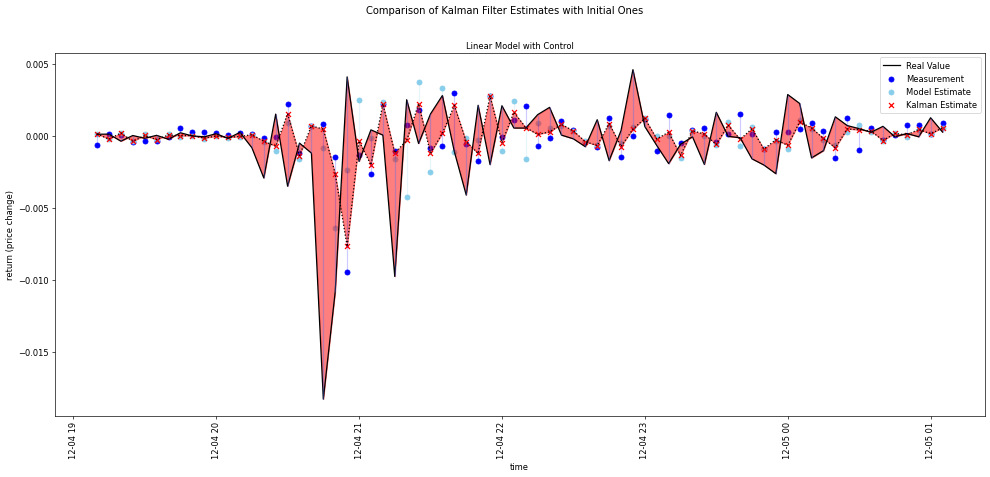

In [9]:
indices = results.index[np.arange(12*6) + int(288*3.8)]
plot_returns_and_filter(results, indices, title)

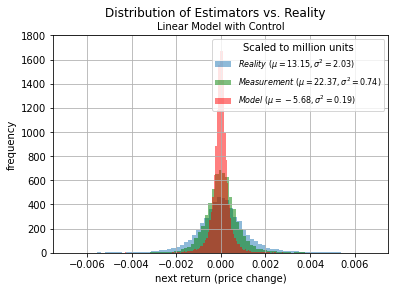

In [9]:
plot_estimators_hist(results, title)

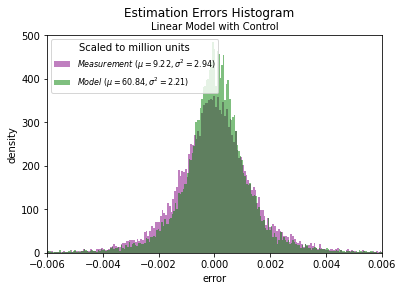

In [17]:
plot_errors_hist(results, title)

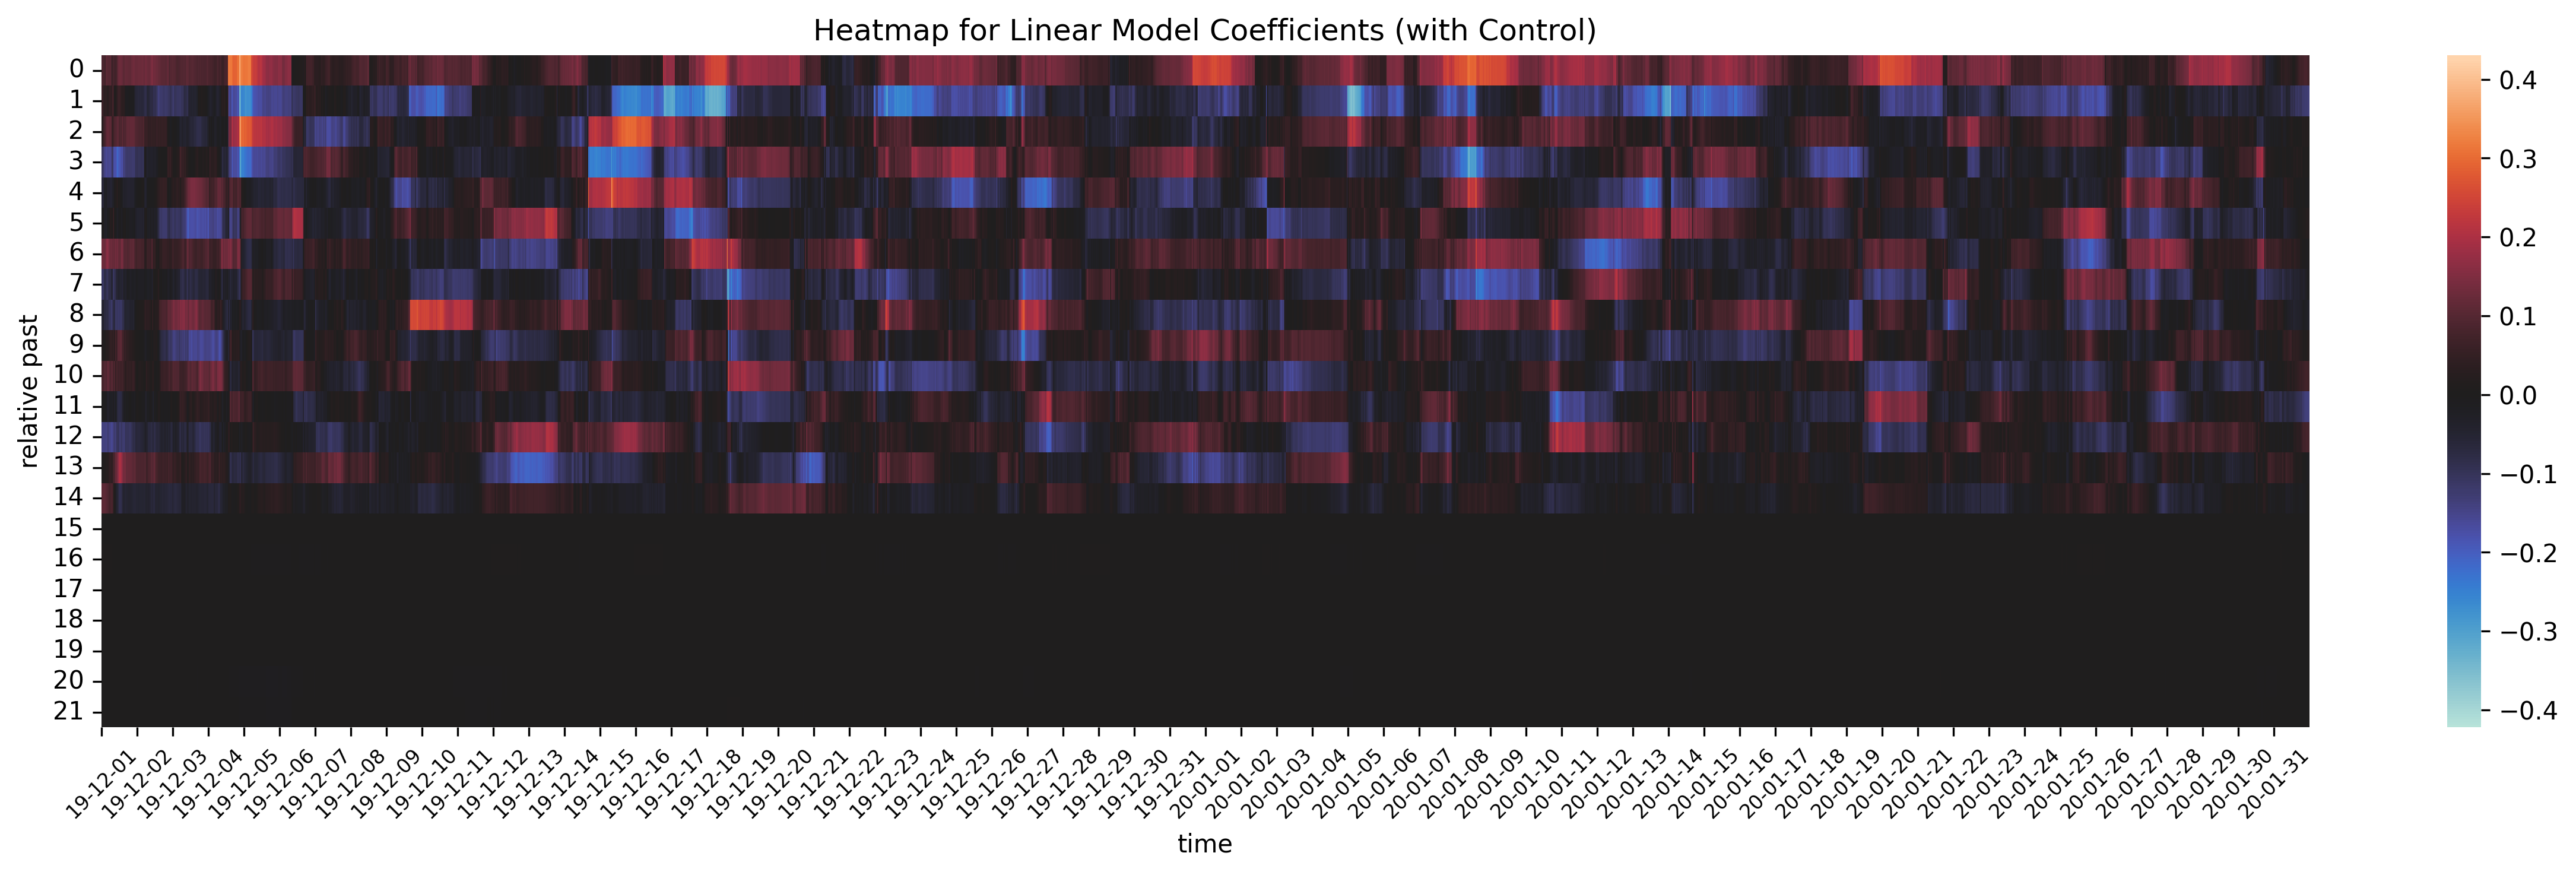

In [18]:
plot_heatmap(results[[f'{i}' for i in range(m+r)]], title)

# Weighted Linear Model with Control

In [19]:
# m = 15
# k = 511
# r = len(features.columns)
#
# X = pd.DataFrame(index=df.index)
# for i in range(m):
#     X[f'Average Price Change from last {i} candle so far'] = \
#         df['Average Price'].pct_change(1 if i == 0 else i).shift(-1 if i == 0 else 0)
#
# period_start = datetime(2019, 12, 1)
# period_start_iloc = np.where(df.index == period_start)[0][0]
# period_end = datetime(2020, 2, 1)
# period_end_iloc = np.where(df.index == period_end)[0][0]
#
# THETA = []
# results = pd.DataFrame(index=df.index)
# results['Prediction'] = None
# results['Measurement'] = None
# results['Model Noise Bias'] = None
#
# alpha = 1. / (0.25)
# W = np.diag(alpha ** np.arange(k) / np.sum(alpha ** np.arange(k)))
# # W = np.diag(np.arange(k) / np.sum(np.arange(k)))
#
# for n in np.arange(period_start_iloc, period_end_iloc):
#     A = np.zeros([k, m+r])
#     A[:, range(m)] = X.iloc[(n-2)-(k-1):(n-2)+1].to_numpy()
#     A[:, range(m, m+r)] = features.iloc[(n-1)-(k-1):(n-1)+1]
#     b = X.iloc[(n-1)-(k-1):(n-1)+1, 0].values
#     theta, _, _, _ = np.linalg.lstsq(np.dot(W, A), np.dot(W, b), rcond=-1)
#     THETA.append(theta)
#     pos = results.index[n]
#     results.loc[pos, 'Model Noise Bias'] = (np.dot(A, theta) - b).mean()
#     results.loc[pos, 'Prediction'] = np.dot(theta[0:m], X.iloc[n-1].values) +\
#                                      np.dot(theta[m:m+r], features.iloc[n].values) +\
#                                      results.loc[pos, 'Model Noise Bias']
#     results.loc[pos, 'Measurement'] = df.iloc[n]['Open'] / df.iloc[n-1]['Average Price'] - 1
#
# indices = df.index[period_start_iloc:period_end_iloc]
# results = results.loc[indices]
# results['Reality'] = df['Average Price Change'].shift(-1).loc[indices].values
# THETA = pd.DataFrame(THETA, index=indices)
# pd.concat([results, THETA], axis=1).to_csv(f'data/weighted_linear_model_with_control[k={k},m={m},a={alpha}]')
#
# t = np.bincount(np.sign(results['Prediction']) == np.sign(results['Reality']))
# print(t[1] / (t[0]+t[1]) * 100)
# print('STANDARD ERRORS')
# for c_label in ['Prediction', 'Measurement']:
#     print('  > {:13s}{:.5f}'.format(c_label + ':', (results[c_label] - results['Reality']).std()))
# print('  > {:13s}{:.5f}'.format('Reality:', (results['Reality']-df['Average Price Change'].loc[indices].values).std()))

In [13]:
# alpha_inv = 99, 95, 90, 80, 50, 25
alpha_inv = 95
title, k, m = f'Weighted ({alpha_inv}%) Linear Model with Control', 511, 15
results = load_results(title, k, m, alpha_inv)
results

,Prediction,Measurement,Model Noise Bias,Reality,0,1,2,3,4,5,...,12,13,14,15,16,17,18,19,20,21
2019-12-01 00:00:00,-0.001976,-0.000246,-0.000649,-0.001031,0.207468,-0.204588,-0.190547,0.262591,-0.217048,0.170642,...,-0.290945,0.294195,-0.153725,0.001058,0.001978,0.000088,-0.001095,-0.000667,-0.002531,-0.002156
2019-12-01 00:05:00,-0.000860,-0.000688,-0.000555,-0.002840,0.178601,-0.186048,-0.159779,0.213159,-0.188530,0.129846,...,-0.263738,0.288161,-0.166073,0.000961,0.001836,0.000076,-0.000971,-0.000674,-0.002006,-0.001805
2019-12-01 00:10:00,-0.004145,-0.000605,-0.001405,-0.000342,0.204436,0.182737,-0.477703,0.272016,0.058398,0.124707,...,0.007105,0.016008,-0.055921,0.001848,-0.001817,0.000017,-0.001496,-0.000368,0.000941,0.000011
2019-12-01 00:15:00,-0.001545,0.000014,-0.001058,-0.001469,0.006856,0.475274,-0.771739,0.405898,0.214901,-0.204241,...,-0.093326,-0.007384,0.037497,0.001610,0.002978,-0.000247,-0.001844,0.000242,0.000069,-0.001323
2019-12-01 00:20:00,-0.000719,-0.001108,-0.001272,-0.000018,-0.088717,0.561590,-0.836998,0.457322,0.186905,-0.201223,...,-0.164578,0.071558,0.017424,0.001869,0.003145,-0.000227,-0.002169,0.000561,0.000430,-0.001268
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-31 23:35:00,-0.000477,0.001077,-0.000868,0.000035,-0.082880,0.275623,0.348180,-0.791492,0.309835,0.069409,...,-0.284818,-0.170754,0.206666,0.002643,0.006997,-0.000933,-0.002065,0.002312,-0.005219,-0.003667
2020-01-31 23:40:00,-0.001215,0.000342,-0.000929,-0.003235,-0.087402,0.276664,0.364435,-0.832161,0.358190,0.057143,...,-0.337215,-0.109399,0.172861,0.002728,0.007986,-0.001022,-0.002238,0.002569,-0.005424,-0.003825
2020-01-31 23:45:00,-0.008207,-0.000170,-0.001434,-0.001554,0.335154,0.377715,0.200131,-0.861041,0.308952,0.547097,...,-0.608521,-0.222683,0.488349,0.003296,0.015023,-0.001364,-0.003568,0.003218,-0.001860,-0.002514
2020-01-31 23:50:00,-0.008569,-0.000945,-0.001492,0.000073,0.066696,0.334883,0.440646,-0.956425,0.002418,0.942649,...,-0.849229,-0.110266,0.384065,0.002737,0.006319,-0.000348,-0.002523,0.002885,-0.001904,-0.001189


In [14]:
apply_kalman_filter(results)
results

,Prediction,Measurement,Model Noise Bias,Reality,0,1,2,3,4,5,...,19,20,21,Measurement Residual,Prediction Residual,Measurement Residual Weighted Variance,Prediction Residual Weighted Variance,Kalman Gain,Estimate,Estimate Uncertainty
2019-12-01 00:00:00,-0.001976,-0.000246,-0.000649,-0.001031,0.207468,-0.204588,-0.190547,0.262591,-0.217048,0.170642,...,-0.000667,-0.002531,-0.002156,0.000785,-0.000945,NaN,NaN,NaN,NaN,NaN
2019-12-01 00:05:00,-0.000860,-0.000688,-0.000555,-0.002840,0.178601,-0.186048,-0.159779,0.213159,-0.188530,0.129846,...,-0.000674,-0.002006,-0.001805,0.002152,0.001980,NaN,NaN,NaN,NaN,NaN
2019-12-01 00:10:00,-0.004145,-0.000605,-0.001405,-0.000342,0.204436,0.182737,-0.477703,0.272016,0.058398,0.124707,...,-0.000368,0.000941,0.000011,-0.000263,-0.003803,NaN,NaN,NaN,NaN,NaN
2019-12-01 00:15:00,-0.001545,0.000014,-0.001058,-0.001469,0.006856,0.475274,-0.771739,0.405898,0.214901,-0.204241,...,0.000242,0.000069,-0.001323,0.001483,-0.000075,NaN,NaN,NaN,NaN,NaN
2019-12-01 00:20:00,-0.000719,-0.001108,-0.001272,-0.000018,-0.088717,0.561590,-0.836998,0.457322,0.186905,-0.201223,...,0.000561,0.000430,-0.001268,-0.001090,-0.000701,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-31 23:35:00,-0.000477,0.001077,-0.000868,0.000035,-0.082880,0.275623,0.348180,-0.791492,0.309835,0.069409,...,0.002312,-0.005219,-0.003667,0.001042,-0.000512,0.000001,0.000001,0.436239,0.000201,5.721917e-07
2020-01-31 23:40:00,-0.001215,0.000342,-0.000929,-0.003235,-0.087402,0.276664,0.364435,-0.832161,0.358190,0.057143,...,0.002569,-0.005424,-0.003825,0.003577,0.002019,0.000001,0.000001,0.448132,-0.000517,6.713620e-07
2020-01-31 23:45:00,-0.008207,-0.000170,-0.001434,-0.001554,0.335154,0.377715,0.200131,-0.861041,0.308952,0.547097,...,0.003218,-0.001860,-0.002514,0.001383,-0.006654,0.000002,0.000005,0.764192,-0.002065,1.163176e-06
2020-01-31 23:50:00,-0.008569,-0.000945,-0.001492,0.000073,0.066696,0.334883,0.440646,-0.956425,0.002418,0.942649,...,0.002885,-0.001904,-0.001189,-0.001019,-0.008642,0.000002,0.000011,0.874856,-0.001899,1.343507e-06


In [10]:
indices = results.index[np.arange(12*6) + int(288*3.8)]
plot_returns_and_filter(results, indices, title)

NameError: name 'alpha_inv' is not defined

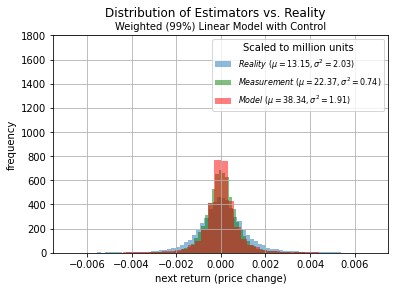

In [21]:
plot_estimators_hist(results, title, limits=None)

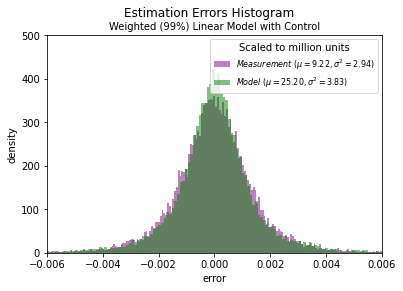

In [22]:
plot_errors_hist(results, title)

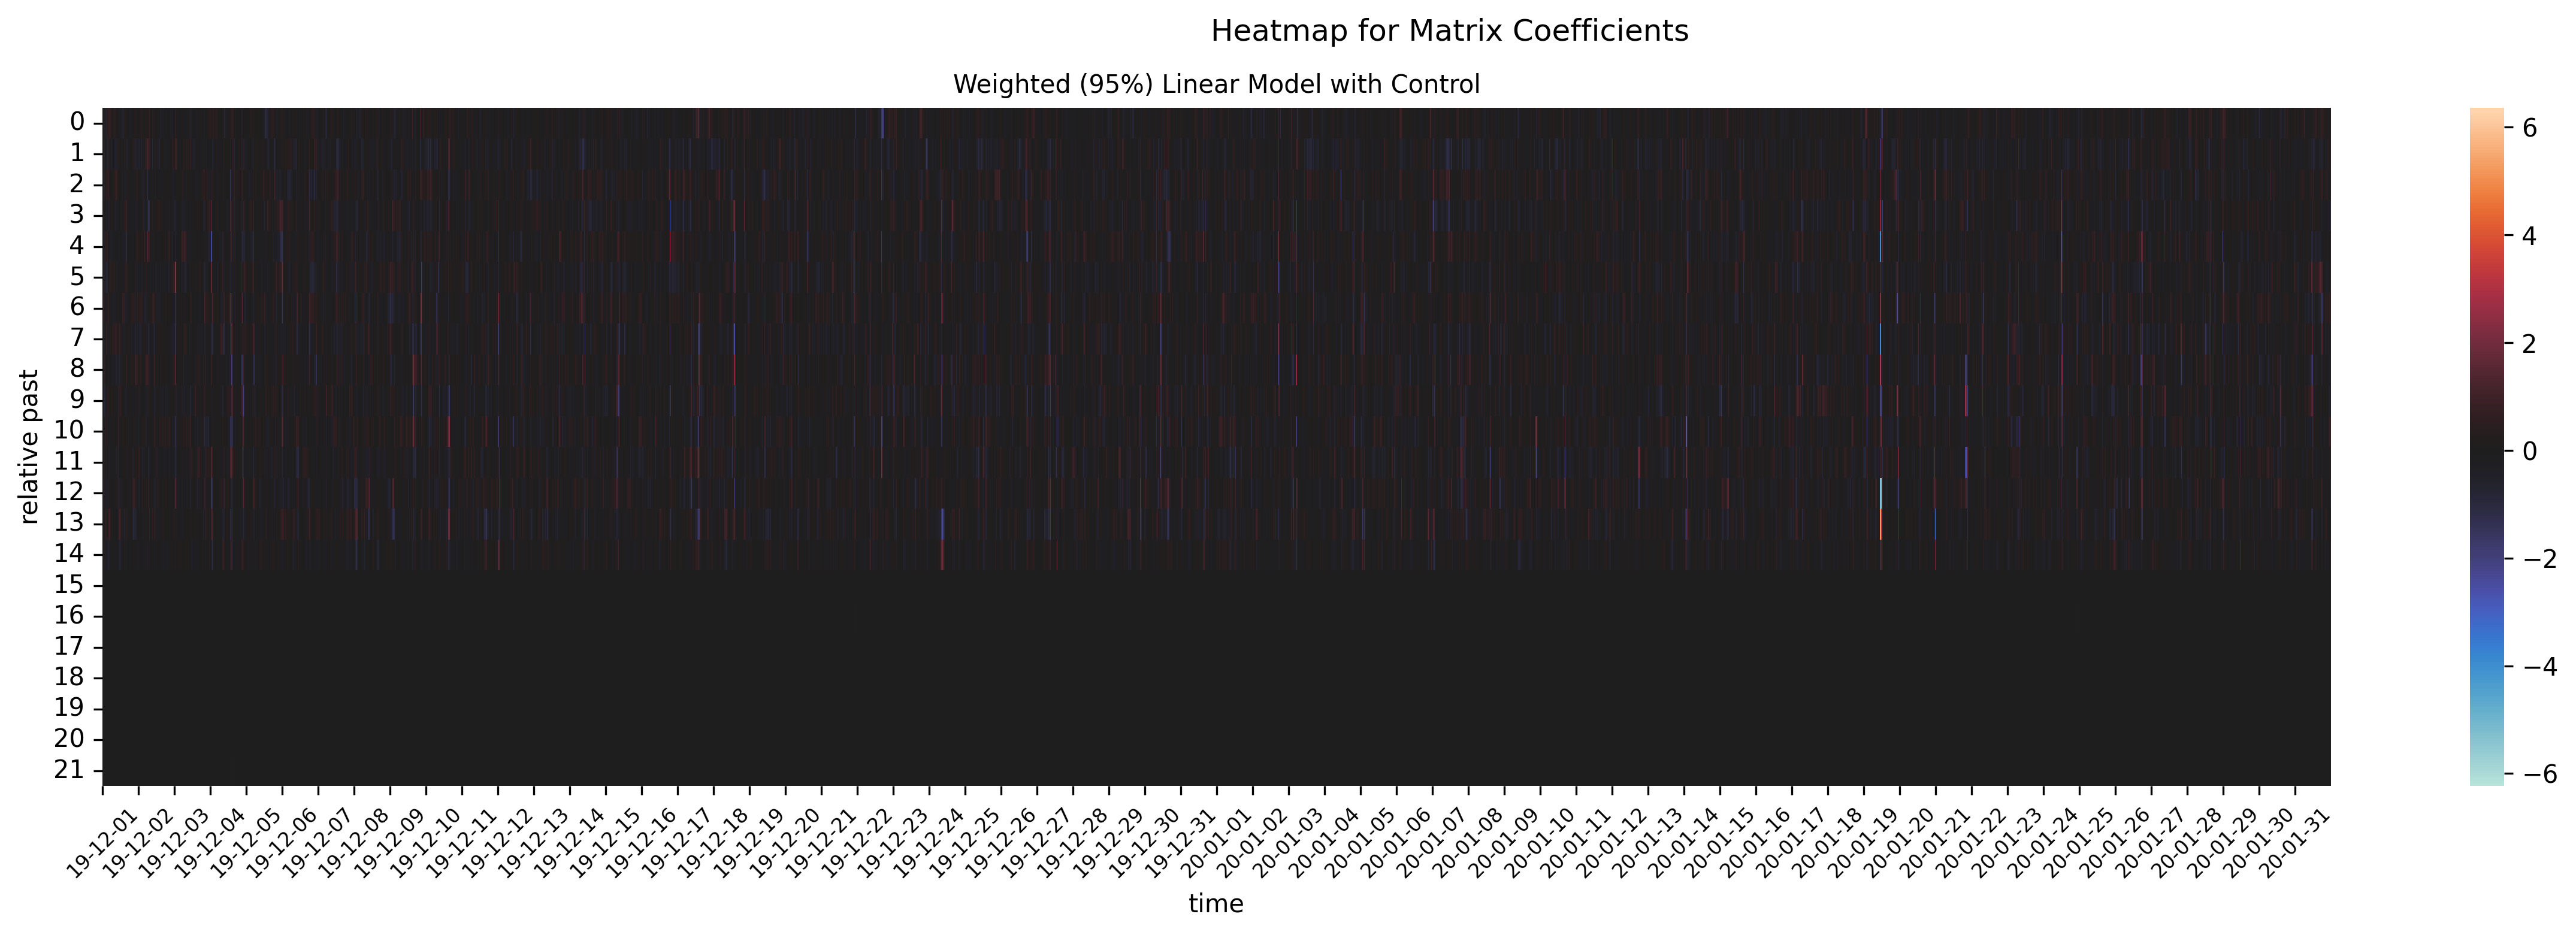

In [75]:
plot_heatmap(results[[f'{i}' for i in range(m+r)]], title)

# Linear Dense Model with control